# Ödometerversuch Input/Output mit Punkten
## Grundlagen
In diesem Notebook wird der Ödometerversuch <strong>ohne</strong> Randbedingungen betrachtet. Es werden vorberechnetet Daten aus der Exceltabelle `files/oedometer/oedo_trainingsdata.xlsx` verwendet.<br>
Das Problem ist wie folgt definiert:
#### Das Problem ist wie folgt definiert:
$$
\begin{array}{rcl}
    \sigma_{t=1} & = & \sigma_{t=0}+\Delta\sigma \\ \\
    \Delta\sigma & = & E_s\cdot \Delta\epsilon \\ 
    E_s & = & \frac{1+e_0}{C_c} \cdot \sigma
\end{array}
\hspace{2cm}
\begin{array}{l}
    \textbf{Annahmen:} \\ \\
    \text{Startwert d. Iteration: } \sigma_0 = 1,00 \\ 
    e_0 = 1,00 \\ 
    C_c = 0,0005
\end{array}
$$

<div = style="text-align: center;">
    <img alt="Problem Oedometer Preview" src="./files/oedometer/problem_preview.png" width="50%" height=auto>
</div>

<br> 

Um das PINA-Model zu testen werden wir folgende vorberechnete Werte verwenden: `Input` {$\sigma_0$, $\Delta\epsilon$}; `Output` {$\sigma_1$}.

## Einstellungen

In [33]:
import ipywidgets as widgets
from IPython.display import display

# Checkbox erstellen
debug_mode = widgets.Checkbox(
    value=False,  # Standard: Ausgeschaltet
    description="Debug Mode aktivieren",
    disabled=False
)

normalize_data = widgets.Checkbox(
    value=False,  # Standard: Ausgeschaltet
    description="Daten normalisieren",
    disabled=False
)

# Checkbox anzeigen
display(debug_mode)
display(normalize_data)


Checkbox(value=False, description='Debug Mode aktivieren')

Checkbox(value=False, description='Daten normalisieren')

In [1]:
import pandas as pd
import numpy as np
from sympy.integrals.heurisch import components

# Excel-Datei laden (ersetze 'datei.xlsx' mit deinem Dateinamen)
file_path = "data/oedometer/oedo_trainingsdata.xlsx"
sheet_name = "Res"

# Excel-Datei mit explizitem Tabellenblatt laden
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Dynamische Ermittlung der letzten Zeile mit Daten
row_start_range = 0  # Startet bei Zeile 6 (0-basiert)
row_end_range = df.dropna(how="all").last_valid_index() + 1  # Letzte Zeile mit Daten

# Spaltenauswahl Spalte B, D und E
selected_columns = [1, 3, 5]  # Spalten-Indices

# Daten extrahieren
data_subset = df.iloc[row_start_range:row_end_range, selected_columns]

data_dict = {col: np.array(data_subset[col]) for col in data_subset.columns}

if debug_mode.value:
    print(data_dict)

ModuleNotFoundError: No module named 'pandas'

## Daten normalisieren

In [25]:
if normalize_data.value:
    data_dict.update({'sigma_0_raw': data_dict.pop('sigma_0')})
    data_dict.update({'sigma_1_raw': data_dict.pop('sigma_1')})
    
    sigma_0_min, sigma_0_max = data_dict['sigma_0_raw'].min(), data_dict['sigma_0_raw'].max()
    sigma_1_min, sigma_1_max = data_dict['sigma_1_raw'].min(), data_dict['sigma_1_raw'].max()
    
    # Min-Max-Normalisierung
    data_dict['sigma_0'] = (data_dict['sigma_0_raw'] - sigma_0_min) / (sigma_0_max - sigma_0_min)
    data_dict['sigma_1'] = (data_dict['sigma_1_raw'] - sigma_1_min) / (sigma_1_max - sigma_1_min)

## Konvertierung zu LabelTensor

In [26]:
import torch
from pina.utils import LabelTensor
from torch import tensor

# Beispiel-Daten
sigma_0_train = LabelTensor(tensor(data_dict['sigma_0'], dtype=torch.float).unsqueeze(-1), ['sigma_0'])
delta_epsilon_train = LabelTensor(tensor(data_dict['delta_epsilon'], dtype=torch.float).unsqueeze(-1), ['delta_epsilon'])
sigma_1_train = LabelTensor(tensor(data_dict['sigma_1'], dtype=torch.float).unsqueeze(-1), ['sigma_1'])

# Kombinieren der Trainingsdaten
input_points_combined = LabelTensor(tensor([data_dict['sigma_0'], data_dict['delta_epsilon']], dtype=torch.float).mT, ['sigma_0', 'delta_epsilon'])

if debug_mode.value:
    print('Data Loaded')
    print(f' sigma_0: {sigma_0_train.size()}')
    print(f' delta_epsilon: {delta_epsilon_train.shape}')
    print(f' sigma_0 und delta_epsilon combined: {input_points_combined.size()}')
    print(f' sigma_1: {sigma_1_train.shape}')


## Problemdefinition

### Hinweise
- Input und Output Werte müssen aus der Excel als Condition übergeben werden.
- Auch wenn die `domain` nicht verwendet wird, muss diese definiert sein und darf nicht leer sein! Generell ist dieses Attribut notwendig um den Wertebereich für die Datengenerierung zu bestimmen.
  - Siehe Kommentar `problem.discretise_domain`. 

In [27]:
from pina.problem import AbstractProblem
from pina.geometry import CartesianDomain
from pina import Condition
class SimpleODE(AbstractProblem):

    # Definition der Eingabe- und Ausgabevariablen basierend auf LabelTensor
    input_variables = input_points_combined.labels
    output_variables = sigma_1_train.labels

    # Wertebereich
    domain = CartesianDomain({'sigma_0': [0, 1], 'delta_epsilon': [0, 1]})  # Wertebereich immer definieren!

    # Definition der Randbedingungen und vorberechnetet Punkte
    conditions = {
        'data': Condition(input_points=input_points_combined, output_points=sigma_1_train),
    }

    output_pts=sigma_1_train

    # Methode zur Definition der "wahren Lösung" des Problems
    def truth_solution(self, pts):
        return torch.exp(pts.extract(['sigma_0']))

# Problem-Instanz erzeugen
problem = SimpleODE()

# Datengenerierung, falls Randbedingungen definiert
# problem.discretise_domain(n=993, mode='random', variables='all', locations='all') # Notwendig, wenn "input_pts" und "output_pts" nicht vorgegeben sind

if debug_mode.value:
    # Debugging-Ausgaben
    print("Geladene Input Variablen: ", problem.input_variables)
    print("Geladene Output Variablen: ", problem.output_variables)
    print('Input points:', problem.input_pts)

## Visualisierung Sampling
Darstellung Input: `sigma_0` und `delta_epsilon`

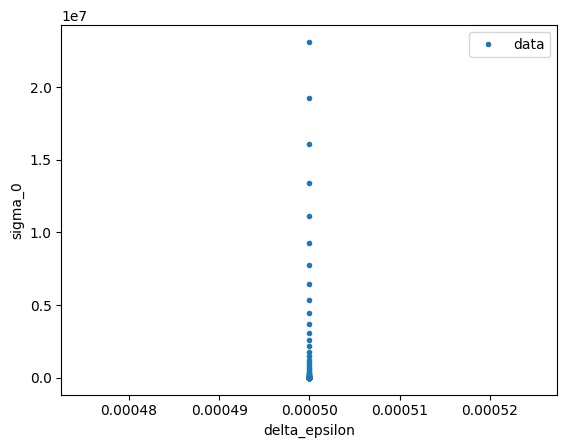

In [28]:
from pina import Plotter

pl = Plotter()
pl.plot_samples(problem=problem, variables=['delta_epsilon','sigma_0'])

In [29]:
from pina import Trainer
from pina.solvers import PINN
from pina.model import FeedForward
from pina.callbacks import MetricTracker
import torch
from pytorch_lightning.loggers import TensorBoardLogger  # Import TensorBoard Logger

# Überprüfen der Größe der Eingabepunkte und Ausgabepunkte
print("Länge der Eingabepunkte (input_pts):", len(problem.input_pts['data']))
print("Länge der Ausgabepunkte (output_pts):", len(problem.output_pts))

# Model erstellen
model = FeedForward(
    layers=[50, 50, 50],
    func=torch.nn.ReLU,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)
)

# PINN-Objekt erstellen
pinn = PINN(problem, model)

# TensorBoard-Logger einrichten
logger = TensorBoardLogger("tensorboard_logs", name="pina_experiment")

# Trainer erstellen mit TensorBoard-Logger
trainer = Trainer(
    solver=pinn,
    max_epochs=200,
    callbacks=[MetricTracker()],
    batch_size=1,
    accelerator='cpu',
    logger=logger,
    enable_model_summary=False,
)


# Training starten
trainer.train()

# Inspect final loss
trainer.logged_metrics


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Länge der Eingabepunkte (input_pts): 94
Länge der Ausgabepunkte (output_pts): 94


Training: |                                                                    | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


{'data_loss': tensor(1.9701e+10), 'mean_loss': tensor(1.9701e+10)}

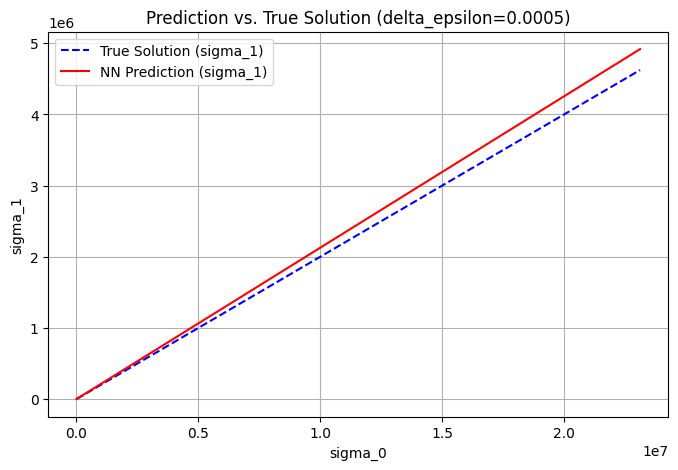

In [30]:
import matplotlib.pyplot as plt
import torch

# Erstelle die Eingabedaten als LabelTensor für das trainierte Modell
input_data = LabelTensor(torch.tensor(
    np.column_stack((data_dict['sigma_0'], data_dict['delta_epsilon'])), dtype=torch.float
), ['sigma_0', 'delta_epsilon'])

# Model-Vorhersage für sigma_1 berechnen
sigma_1_pred = pinn(input_data).detach().numpy()

# Plot der wahren vs. vorhergesagten Werte
plt.figure(figsize=(8, 5))

plt.plot(data_dict['sigma_0'], data_dict['sigma_1'], label="True Solution (sigma_1)", linestyle='dashed', color='blue')
plt.plot(data_dict['sigma_0'], sigma_1_pred, label="NN Prediction (sigma_1)", linestyle='solid', color='red')

plt.xlabel("sigma_0")
plt.ylabel("sigma_1")
plt.title("Prediction vs. True Solution (delta_epsilon=0.0005)")
plt.legend()
plt.grid()
plt.show()


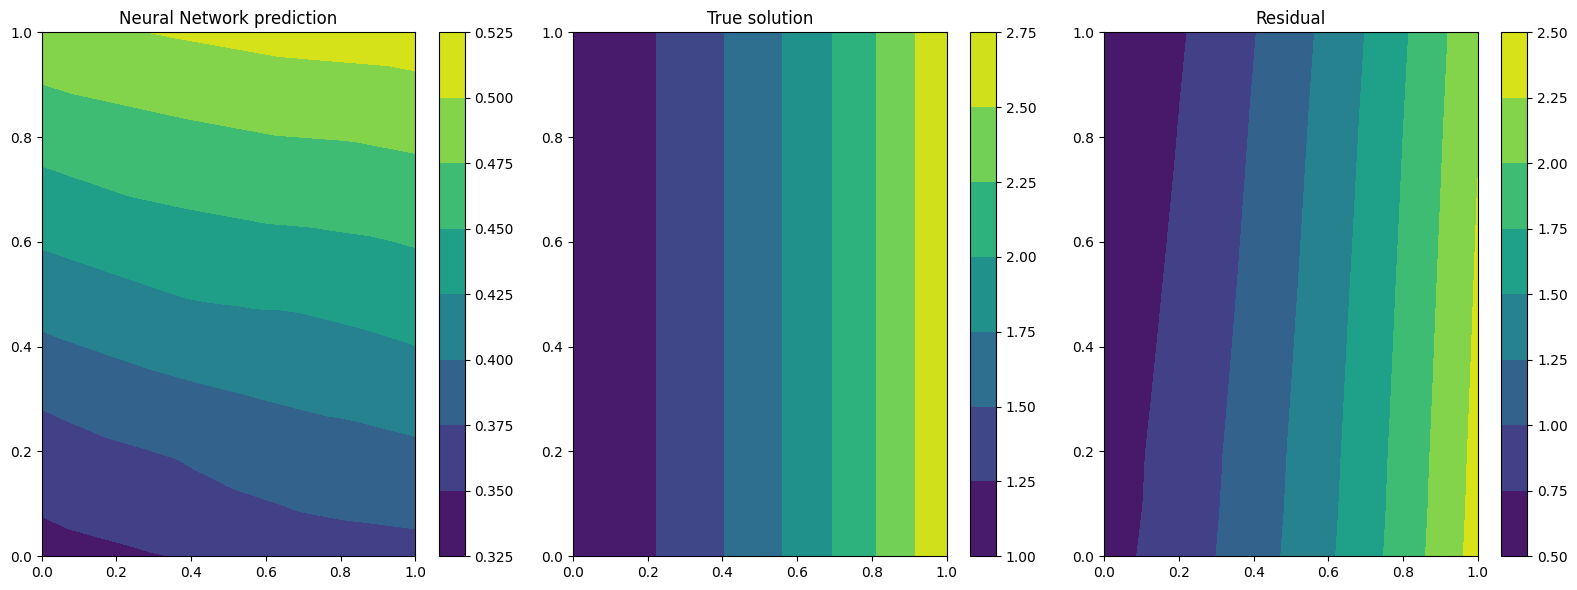

In [31]:
pl.plot(solver=pinn)

## Visualisierung Loss-Kurve


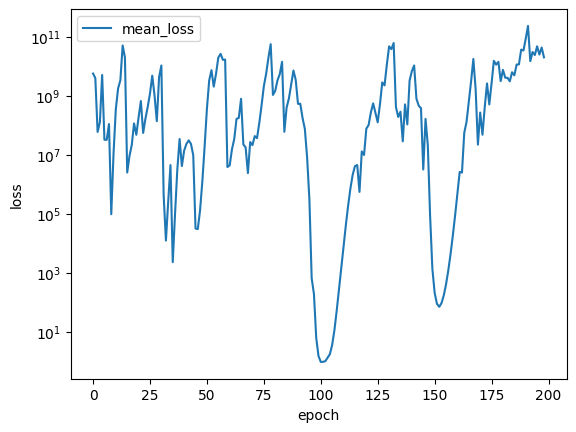

In [32]:
# plotting the solution
pl.plot_loss(trainer, label='mean_loss', logy=True)